In [1]:
import sys

sys.path.append("../")

A place to test random stuff

In [2]:
import torch
import torch.nn as nn
from monkey.model.utils import (
    get_classification_metrics,
    get_activation_function,
)
from monkey.model.loss_functions import get_loss_function, dice_coeff
import numpy as np
from pprint import pprint
import segmentation_models_pytorch as smp
from monkey.data.data_utils import generate_regression_map
import matplotlib.pyplot as plt

/home/u1910100/miniconda3/envs/tiatoolbox/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


tensor([[[[0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 1., 1., 1., 0., 0.],
          [0., 0., 0., 0., 1., 1., 1., 0., 0.],
          [0., 0., 0., 0., 1., 1., 1., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.]]]])


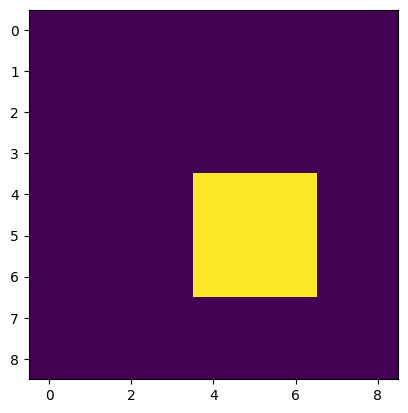

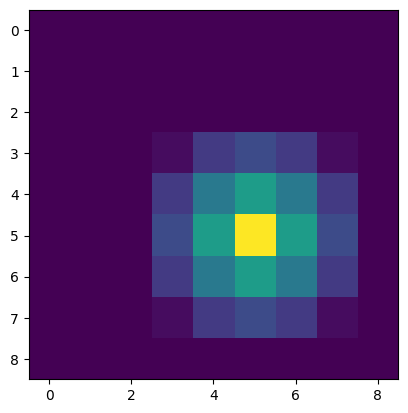

weight_map
tensor([[[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000],
          [0.0000, 0.0000, 0.0000, 0.0343, 0.1688, 0.2302, 0.1688, 0.0343,
           0.0000],
          [0.0000, 0.0000, 0.0000, 0.1688, 0.4054, 0.5516, 0.4054, 0.1688,
           0.0000],
          [0.0000, 0.0000, 0.0000, 0.2302, 0.5516, 1.0000, 0.5516, 0.2302,
           0.0000],
          [0.0000, 0.0000, 0.0000, 0.1688, 0.4054, 0.5516, 0.4054, 0.1688,
           0.0000],
          [0.0000, 0.0000, 0.0000, 0.0343, 0.1688, 0.2302, 0.1688, 0.0343,
           0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000]]]], dtype=torch.float64)
weighted bce loss
tensor(2.7771, dtype=torch.float64)
bce loss
tensor(2.4863, dtype=torch.float64)


In [24]:
loss_fn = get_loss_function('Weighted_BCE_Jaccard')

bce_loss_fn = get_loss_function('Weighted_BCE')
# loss_fn.set_alpha(0.5)
# focal_loss_fn = smp.losses.FocalLoss(mode='binary', alpha=0.25, gamma=2, reduction=None)

with torch.no_grad():
    y_true = torch.zeros(size=(1,1,9,9))
    y_true[0,0,4:7,4:7] = 1
    print(y_true)
    plt.imshow(y_true[0,0])
    plt.show()

    centroid_map = np.zeros((9,9))
    centroid_map[5,5] = 1
    weight_map = generate_regression_map(centroid_map, d_thresh=3, alpha=1, scale=1)
    plt.imshow(weight_map)
    plt.show()

    weight_map = torch.tensor(weight_map).unsqueeze(0).unsqueeze(0)
    print("weight_map")
    print(weight_map)

    y_pred = torch.zeros(size=(1,1,9,9))
    y_pred[0,0,4:7,4:7] = 0.5
    y_pred[0,0,5,5] = 0.9
    # print(y_pred)

    loss = loss_fn.compute_loss(y_true, y_pred, weight_map)
    bce_loss = bce_loss_fn.compute_loss(y_true, y_pred, weight_map)
    print("weighted bce loss")
    print(loss)
    print("bce loss")
    print(bce_loss)
    # weighted_loss = loss * weight_map
    # print("weighted loss")
    # print(weighted_loss)

    # print(loss.mean())
    # print(weighted_loss.mean())

CONCH

In [ ]:
from conch.open_clip_custom import (
    create_model_from_pretrained,
    tokenize,
    get_tokenizer,
)
import torch
import os
from PIL import Image
from pathlib import Path
from tqdm.auto import tqdm

In [ ]:
model_cfg = "conch_ViT-B-16"
device = torch.device(
    "cuda:0" if torch.cuda.is_available() else "cpu"
)
checkpoint_path = "/home/u1910100/Downloads/pytorch_model.bin"
model, preprocess = create_model_from_pretrained(
    model_cfg, checkpoint_path, device=device
)
_ = model.eval()

tokenizer = get_tokenizer()
classes = ["lymphocyte", "monocyte"]
prompts = [
    "a PAS stained image of a lymphocyte",
    "a PAS stained image of a monocyte",
]

tokenized_prompts = tokenize(texts=prompts, tokenizer=tokenizer).to(
    device
)
tokenized_prompts.shape

In [ ]:
from monkey.data.dataset import get_classification_dataloaders
from monkey.config import TrainingIOConfig

IOconfig = TrainingIOConfig(
    dataset_dir="/home/u1910100/Documents/Monkey/classification",
    save_dir="./",
)
IOconfig.set_image_dir(
    "/home/u1910100/Documents/Monkey/classification/patches"
)
IOconfig.set_mask_dir(
    "/home/u1910100/Documents/Monkey/classification/patches"
)
batch_size = 32
train_loader, val_loader = get_classification_dataloaders(
    IOconfig,
    val_fold=1,
    batch_size=batch_size,
    do_augmentation=True,
)

In [ ]:
pred_probs_list = []
true_labels_list = []

for data in tqdm(val_loader):
    file_ids = data["id"]

    images, true_labels = (
        data["image"].cuda().float(),
        data["label"].cpu().tolist(),
    )

    true_labels_list.extend(true_labels)
    pred_probs = []

    with torch.inference_mode():
        image_embedings = model.encode_image(images)
        text_embedings = model.encode_text(tokenized_prompts)
        sim_scores = (
            (
                image_embedings
                @ text_embedings.T
                * model.logit_scale.exp()
            )
            .softmax(dim=-1)
            .cpu()
            .numpy()
        )

        pred_probs_list.extend(sim_scores[:, 1])

In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
from monkey.model.utils import get_classification_metrics

pred_probs_list = np.array(pred_probs_list)
true_labels_list = np.array(true_labels_list)
fpr, tpr, thresholds = metrics.roc_curve(
    true_labels_list, pred_probs_list
)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(
    fpr=fpr,
    tpr=tpr,
    roc_auc=roc_auc,
    estimator_name="cell classifier",
)
display.plot()
plt.show()

thresh = 0.5
pred_labels_list = np.where(pred_probs_list > thresh, 1, 0)
scores = get_classification_metrics(
    true_labels_list, pred_labels_list
)
print(scores)
metrics.ConfusionMatrixDisplay.from_predictions(
    true_labels_list,
    pred_labels_list,
    display_labels=["lymphocyte", "monocyte"],
)
plt.show()

In [ ]:
data = next(iter(val_loader))
images = data["image"].to("cuda").float()
print(data["label"])

with torch.inference_mode():
    image_embedings = model.encode_image(images)
    text_embedings = model.encode_text(tokenized_prompts)
    sim_scores = (
        (image_embedings @ text_embedings.T * model.logit_scale.exp())
        .softmax(dim=-1)
        .cpu()
        .numpy()
    )

pred_class = sim_scores.argmax()
print(pred_class)
print(sim_scores)
print(sim_scores[:, 1])
# print("Predicted class:", classes[sim_scores.argmax()])
# print(
#     "Normalized similarity scores:",
#     [
#         f"{cls}: {score:.3f}"
#         for cls, score in zip(classes, sim_scores[0])
#     ],
# )

CellViT

In [ ]:
import sys

sys.path.append("../")
import torch
from monkey.model.cellvit.cellvit import CellViT256, CellVit256_Unet

model_path = "/home/u1910100/Downloads/HIPT_vit256_small_dino.pth"
device = "cuda"

model = CellVit256_Unet(num_decoders=3)

model.load_pretrained_encoder(model_path)

model.eval()
print(model)

test = torch.rand(size=(4, 3, 256, 256))
out = model(test)
print(out.shape)

MapDe Filter

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import sys
from scipy import ndimage, signal

sys.path.append("../")
from monkey.data.data_utils import erode_mask, generate_regression_map
import cv2
from skimage import draw

cell_mask = np.zeros(shape=(256, 256), dtype=np.uint8)
rr, cc = draw.ellipse(100, 100, 1, 1, shape=cell_mask.shape)
# rr, cc = 100, 100
cell_mask[rr, cc] = 1
plt.imshow(cell_mask)
plt.show()


def gauss_2d_filter(shape=(11, 11)):
    sigma = int((shape[0] - 1) / 6)
    m, n = [(ss - 1.0) / 2.0 for ss in shape]
    y, x = np.ogrid[-m : m + 1, -n : n + 1]
    h = np.exp(-(x * x + y * y) / (2.0 * sigma * sigma))
    h[h < np.finfo(h.dtype).eps * h.max()] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh

    h = h / (h[int(m), int(n)])
    return h


dist_filter = gauss_2d_filter(shape=(17, 17))
plt.imshow(dist_filter)
plt.show()
# cell_mask = generate_regression_map(cell_mask, d_thresh=5, alpha=0.5, scale=1)
# plt.imshow(cell_mask)
# plt.show()

cell_mask = signal.convolve2d(cell_mask, dist_filter)
print(np.max(cell_mask))
plt.imshow(cell_mask)
plt.show()

Multihead Unet

In [ ]:
import sys

sys.path.append("../")
from pprint import pprint
import torch

torch.manual_seed(0)
from torchvision.models.efficientnet import (
    efficientnet_b0,
)
from monkey.model.efficientunetb0.architecture import (
    get_multihead_efficientunet,
)
from torchinfo import summary


model = get_multihead_efficientunet(
    out_channels=[2, 1], pretrained=True
)
model.eval()
model.to("cuda")
summary(model, input_size=(1, 3, 256, 256))

In [ ]:
with torch.no_grad():
    test_input = torch.ones(
        size=(1, 3, 256, 256), dtype=torch.float, device="cuda"
    )
    model_out = model(test_input)
    pprint(model_out)

MapDe model

In [ ]:
import sys
import torch

sys.path.append("../")

from monkey.model.mapde.model import MapDe
from monkey.data.dataset import get_detection_dataloaders
from monkey.config import TrainingIOConfig
import matplotlib.pyplot as plt
import numpy as np
from monkey.data.data_utils import imagenet_denormalise
import torch

use_nuclick_masks = False
batch_size = 1
module = "detection"

IOconfig = TrainingIOConfig(
    dataset_dir="/home/u1910100/Documents/Monkey/patches_256",
    save_dir="./",
)


train_loader, val_loader = get_detection_dataloaders(
    IOconfig,
    val_fold=5,
    dataset_name="detection",
    batch_size=batch_size,
    disk_radius=1,
    regression_map=False,
    do_augmentation=True,
    module=module,
    use_nuclick_masks=use_nuclick_masks,
    include_background_channel=False,
)


model = MapDe(3, 30, 50, num_classes=1, filter_size=31)
model.eval()
# print(model)
test_input = torch.ones(size=(4, 3, 252, 252), dtype=torch.float)

with torch.no_grad():
    out = model(test_input)
print(f"output size = {out.size()}")
# print(torch.max(out))

In [ ]:
data = next(iter(train_loader))

fig, axes = plt.subplots(1, 3, figsize=(18, 18))

image = data["image"][0].numpy()
image = np.moveaxis(image, 0, 2)
image = imagenet_denormalise(image)
axes[0].imshow(image)

mask = data["mask"]
mask_filtered = model.blur_cell_points(mask)


axes[1].imshow(image, alpha=0.5)
mask_filtered_numpy = mask_filtered.numpy()
axes[1].imshow(mask_filtered_numpy[0][0], alpha=0.5)
axes[2].imshow(mask_filtered_numpy[0][0])
plt.show()

In [ ]:
test_logits = torch.rand(size=(2, 3, 252, 252))

model.eval()
with torch.no_grad():
    logits = model(test_logits)
    probs = model.logits_to_probs(logits)
print(logits)

out_masks = model.postproc(logits)
out_masks = out_masks[:, np.newaxis, :, :]
out_masks = model.blur_cell_points(out_masks)

logits = logits.numpy(force=True)
probs = probs.numpy(force=True)


plt.imshow(logits[0][0])
plt.show()
print(np.max(logits[0][0]))

plt.imshow(probs[0][0])
plt.show()

# print(np.max(logits))
plt.imshow(out_masks[0][0])
plt.show()

import skimage

inflamm_labels = skimage.measure.label(out_masks[0][0])
inflamm_stats = skimage.measure.regionprops(
    inflamm_labels, intensity_image=probs[0][0]
)
for region in inflamm_stats:
    centroid = region["centroid"]

    c, r, confidence = (
        centroid[1],
        centroid[0],
        region["mean_intensity"],
    )
    print(c, r, confidence)

HoverNext

In [ ]:
import sys
import torch
from torchinfo import summary
from pprint import pprint

sys.path.append("../")
import numpy as np
from monkey.model.hovernext.model import (
    get_custom_hovernext,
    get_convnext_unet,
    get_timm_encoder,
    load_encoder_weights,
)

model = get_custom_hovernext(
    enc="tf_efficientnetv2_m.in21k",
    pretrained=True,
    num_heads=3,
    decoders_out_channels=[3, 3, 3],
    attention_type='scse',
    use_batchnorm=True,
)
# model = get_convnext_unet(
#     out_classes=2, use_batchnorm=True, attention_type="scse"
# )
# checkpoint_path = "/home/u1910100/Downloads/lizard_convnextv2_large/train/best_model"
# model = load_encoder_weights(model, checkpoint_path)
model.eval()
model.to("cuda")
pprint(summary(model, input_size=(1, 3, 256, 256)))
pprint(model)

In [ ]:
import torch

test_input = torch.ones(
    size=(1, 3, 256, 256), dtype=torch.float, device="cuda"
)

with torch.no_grad():
    out = model(test_input)

print(out.shape)

Pannuke Masks

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import sys

sys.path.append("../")
from monkey.data.data_utils import (
    generate_regression_map,
    dilate_mask,
    load_image,
    load_mask,
)
from monkey.data.dataset import class_mask_to_multichannel_mask

cell_mask = np.zeros(shape=(256, 256), dtype=np.uint8)
cell_mask[100, 100] = 1

cell_mask = dilate_mask(cell_mask, 3)

plt.imshow(cell_mask)
plt.show()

cell_mask = generate_regression_map(
    cell_mask, d_thresh=7, alpha=3, scale=1
)
plt.imshow(cell_mask)
plt.show()

In [ ]:
mask_path = "/home/u1910100/Documents/Monkey/patches_256/annotations/masks/C_P000029_18592_66528_18848_66784.npy"
mask = np.load(mask_path)
class_mask = class_mask_to_multichannel_mask(mask)

plt.imshow(class_mask[0])
plt.show()
plt.imshow(class_mask[1])
plt.show()

import scipy.ndimage as ndi

dist = ndi.distance_transform_edt(class_mask[0] == 0)
M = (np.exp(3 * (1 - dist / 7)) - 1) / (np.exp(3) - 1)
M[M < 0] = 0
M *= 1

plt.imshow(M)
plt.show()

Strong Augment

In [7]:
import torchvision.transforms as T
from strong_augment import StrongAugment
import numpy as np
import matplotlib.pyplot as plt

trnsf = T.Compose(
    [
        StrongAugment(
            operations=[2, 3, 4], probabilites=[0.5, 0.3, 0.2]
        )
    ]
)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Load the images
image = np.load(
    "/home/u1910100/Documents/Monkey/patches_256/images/A_P000001_9632_87360_9888_87616.npy"
)
aug_image = trnsf(image)

# Create a subplot with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Display the original image
axes[0].imshow(image)
axes[0].set_title("Original Image")
axes[0].axis("off")

# image = image / 255.0
# Display the augmented image
axes[1].imshow(
    aug_image
)  # Permute the dimensions for correct display
axes[1].set_title("Augmented Image")
axes[1].axis("off")

# Show the plot
plt.show()

Modified Self attention

In [ ]:
import sys
import torch
from torchinfo import summary
from pprint import pprint

sys.path.append("../")
import numpy as np
from monkey.model.hovernext.modified_self_attention import (
    get_model,
)

model = get_model(
    enc="convnextv2_tiny.fcmae_ft_in22k_in1k",
    pretrained=False,
)
pprint(summary(model, input_size=(1, 3, 256, 256)))

test_input = torch.ones(
    size=(1, 3, 256, 256), dtype=torch.float, device="cuda"
)
with torch.no_grad():
    out = model(test_input)
print(out.shape)

In [ ]:
import sys
import torch
from torchinfo import summary
from pprint import pprint

sys.path.append("../")
import numpy as np
from monkey.model.hovernext.modified_model import (
    get_modified_hovernext
)


model = get_modified_hovernext("convnextv2_tiny.fcmae_ft_in22k_in1k", pretrained=False)
model.to("cuda")
test_input = torch.ones(
    size=(1, 3, 256, 256), dtype=torch.float, device="cuda"
)
with torch.no_grad():
    out = model(test_input)
print(out.shape)
print(summary(model, input_size=(1, 3, 256, 256)))

Process NuClick Masks

In [ ]:
import os
from multiprocessing import Pool

import numpy as np
from scipy import ndimage
from matplotlib import pyplot as plt

NUCLICK_DIR = "/home/u1910100/Documents/Monkey/patches_256/annotations/nuclick_hovernext"

SAVE_DIR = "/home/u1910100/Documents/Monkey/patches_256/annotations/nuclick_masks_processed_v2"


def process_instance_and_class_map(instance_map, class_map):
    # get initial binary mask from instance map
    binary_mask = np.zeros(shape=(instance_map.shape), dtype=np.uint8)
    binary_mask = np.where(instance_map > 0, 1, 0).astype(np.uint8)

    lymph_mask = np.where(class_map == 1, 1, 0).astype(np.uint8)
    mono_mask = np.where(class_map == 2, 1, 0).astype(np.uint8)

    # Erode binary mask by gradient map
    sx = ndimage.sobel(instance_map, axis=0)
    sy = ndimage.sobel(instance_map, axis=1)
    inflamm_gradient = np.hypot(sx, sy)
    inflamm_gradient = (inflamm_gradient > 0).astype(np.uint8)
    binary_mask[inflamm_gradient == 1] = 0

    # Use instance mask to separate lymph and mono instances
    lymph_mask[binary_mask == 0] = 0
    mono_mask[binary_mask == 0] = 0

    # Erode lymph_mask by gradient map
    sx = ndimage.sobel(lymph_mask, axis=0)
    sy = ndimage.sobel(lymph_mask, axis=1)
    lymph_gradient = np.hypot(sx, sy)
    lymph_gradient = (lymph_gradient > 0).astype(np.uint8)
    lymph_mask[lymph_gradient == 1] = 0

    # Erode mono_mask by gradient map
    sx = ndimage.sobel(mono_mask, axis=0)
    sy = ndimage.sobel(mono_mask, axis=1)
    mono_gradient = np.hypot(sx, sy)
    mono_gradient = (mono_gradient > 0).astype(np.uint8)
    mono_mask[mono_gradient == 1] = 0

    return {
        "inflamm_mask": binary_mask,
        "inflamm_contour_mask": inflamm_gradient,
        "lymph_mask": lymph_mask,
        "lymph_contour_mask": lymph_gradient,
        "mono_mask": mono_mask,
        "mono_contour_mask": mono_gradient,
    }


def process_nuclick_data_file(file_name):
    data_path = os.path.join(NUCLICK_DIR, file_name)
    data = np.load(data_path)

    print(data.shape)

    image = data[:, :, 0:3]
    image = image.astype(np.uint8)

    instance_map = data[:, :, 3]
    class_map = data[:, :, 4]

    processed_masks = process_instance_and_class_map(
        instance_map, class_map
    )

    new_data = np.zeros(
        shape=(data.shape[0], data.shape[1], 9), dtype=np.uint8
    )
    new_data[:, :, 0:3] = image
    new_data[:, :, 3] = processed_masks["inflamm_mask"]
    new_data[:, :, 4] = processed_masks["inflamm_contour_mask"]
    new_data[:, :, 5] = processed_masks["lymph_mask"]
    new_data[:, :, 6] = processed_masks["lymph_contour_mask"]
    new_data[:, :, 7] = processed_masks["mono_mask"]
    new_data[:, :, 8] = processed_masks["mono_contour_mask"]

    # save_path = os.path.join(SAVE_DIR, file_name)
    # np.save(save_path, new_data)
    return new_data


files = os.listdir(NUCLICK_DIR)

for file in files:

    new_data = process_nuclick_data_file(file)

    # Plot new data
    fig, axes = plt.subplots(1, 7, figsize=(18, 18))
    axes[0].imshow(new_data[:, :, 0:3])
    axes[0].title.set_text("Image")
    axes[1].imshow(new_data[:, :, 3])
    axes[1].title.set_text("Inflammation Mask")
    axes[2].imshow(new_data[:, :, 4])
    axes[2].title.set_text("Inflammation Contour Mask")
    axes[3].imshow(new_data[:, :, 5])
    axes[3].title.set_text("Lymph Mask")
    axes[4].imshow(new_data[:, :, 6])
    axes[4].title.set_text("Lymph Contour Mask")
    axes[5].imshow(new_data[:, :, 7])
    axes[5].title.set_text("Mono Mask")
    axes[6].imshow(new_data[:, :, 8])
    axes[6].title.set_text("Mono Contour Mask")
    plt.show()

Test

In [ ]:
from tiatoolbox.wsicore.wsireader import WSIReader

wsi_path = "/home/u1910100/Documents/Monkey/test/input/images/kidney-transplant-biopsy-wsi-pas/A_P000002_PAS_CPG.tif"
mask_path = "/home/u1910100/Documents/Monkey/test/input/images/tissue-mask/A_P000002_mask.tif"

wsi_reader = WSIReader.open(wsi_path)
mask_reader = WSIReader.open(mask_path)

wsi_shape = wsi_reader.slide_dimensions(resolution=0, units="level")
mask_shape = mask_reader.slide_dimensions(resolution=0, units="level")

print(wsi_shape, mask_shape)

print(mask_reader.info.as_dict())